In [285]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from astropy.stats import sigma_clip
from scipy.stats import entropy

rng = np.random.default_rng()

In [286]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0', 'log_x1']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni', 'log_mej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [287]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [288]:
data = np.load("fitted_sne_real_012326.npz", allow_pickle=True)
phot_data = np.load("fitted_sne_real_012126_phot.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
true_ia_phot_sne = phot_data['ia']
true_ibc_phot_sne = phot_data['ibc']
all_phot_sne = np.concatenate((true_ia_phot_sne, true_ibc_phot_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(252, 2674, 0.9057591623036649)

In [289]:
sum(np.array([sn.ia_fit['x1'] for sn in all_sne]) <= 0), min(np.array([sn.ia_fit['x1'] for sn in all_sne]))

(1083, -4.9999999991920685)

In [290]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

for sn in all_phot_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

In [291]:
all_sne[100].true_class

'SN Ia'

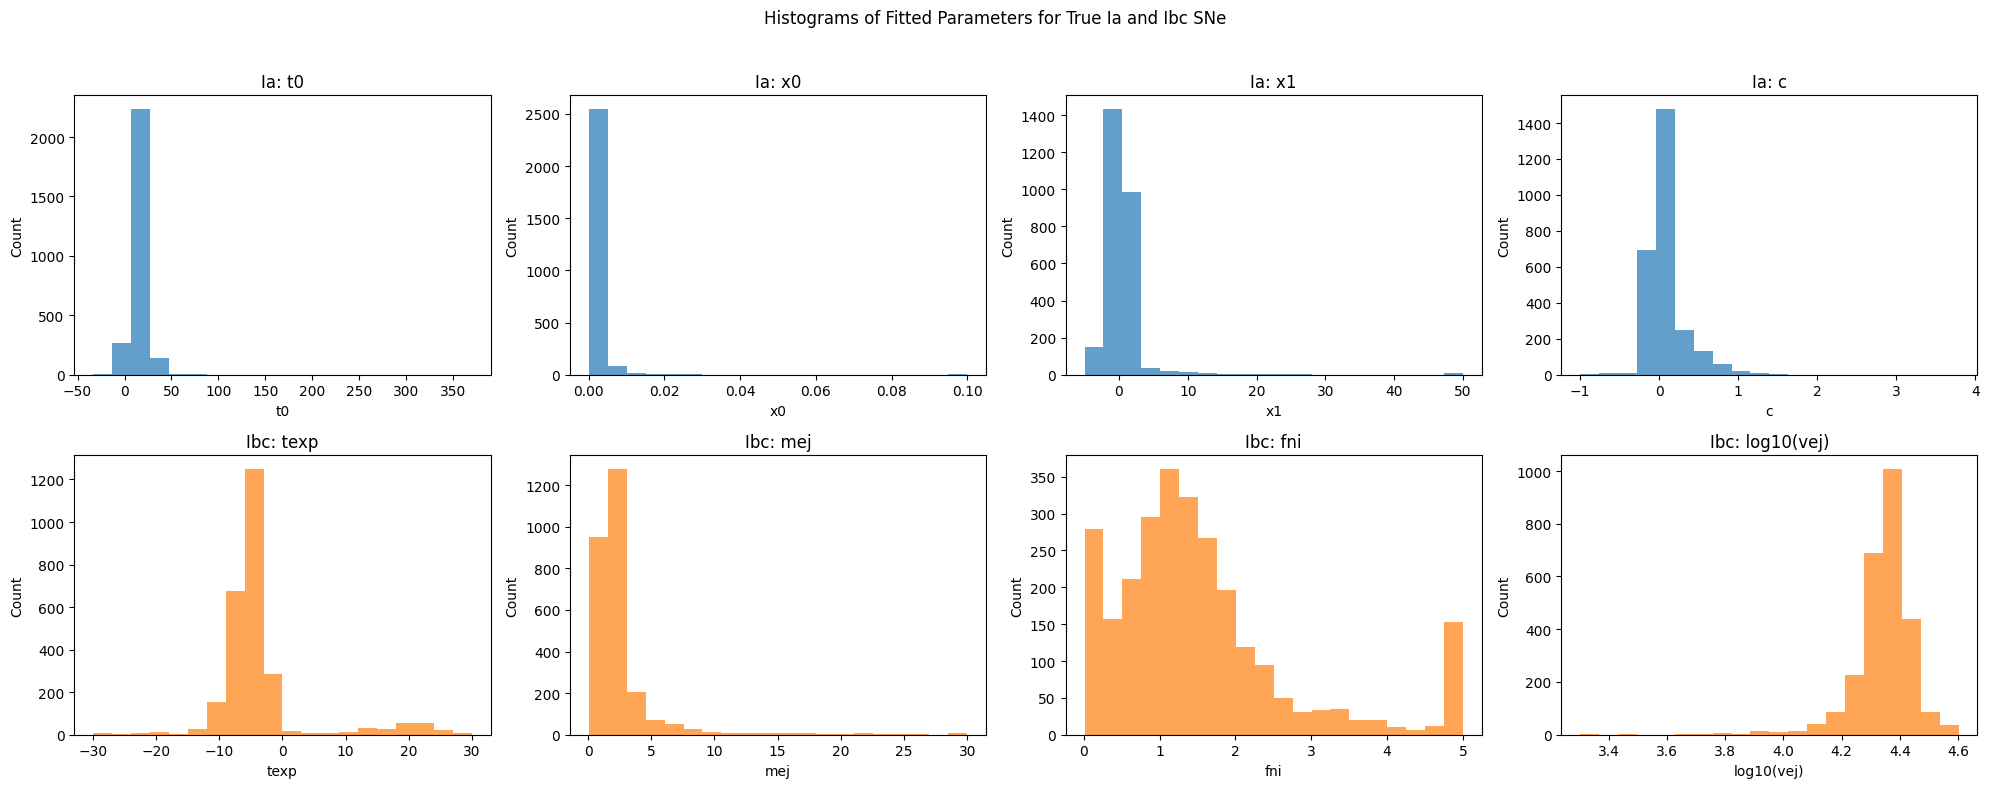

In [292]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

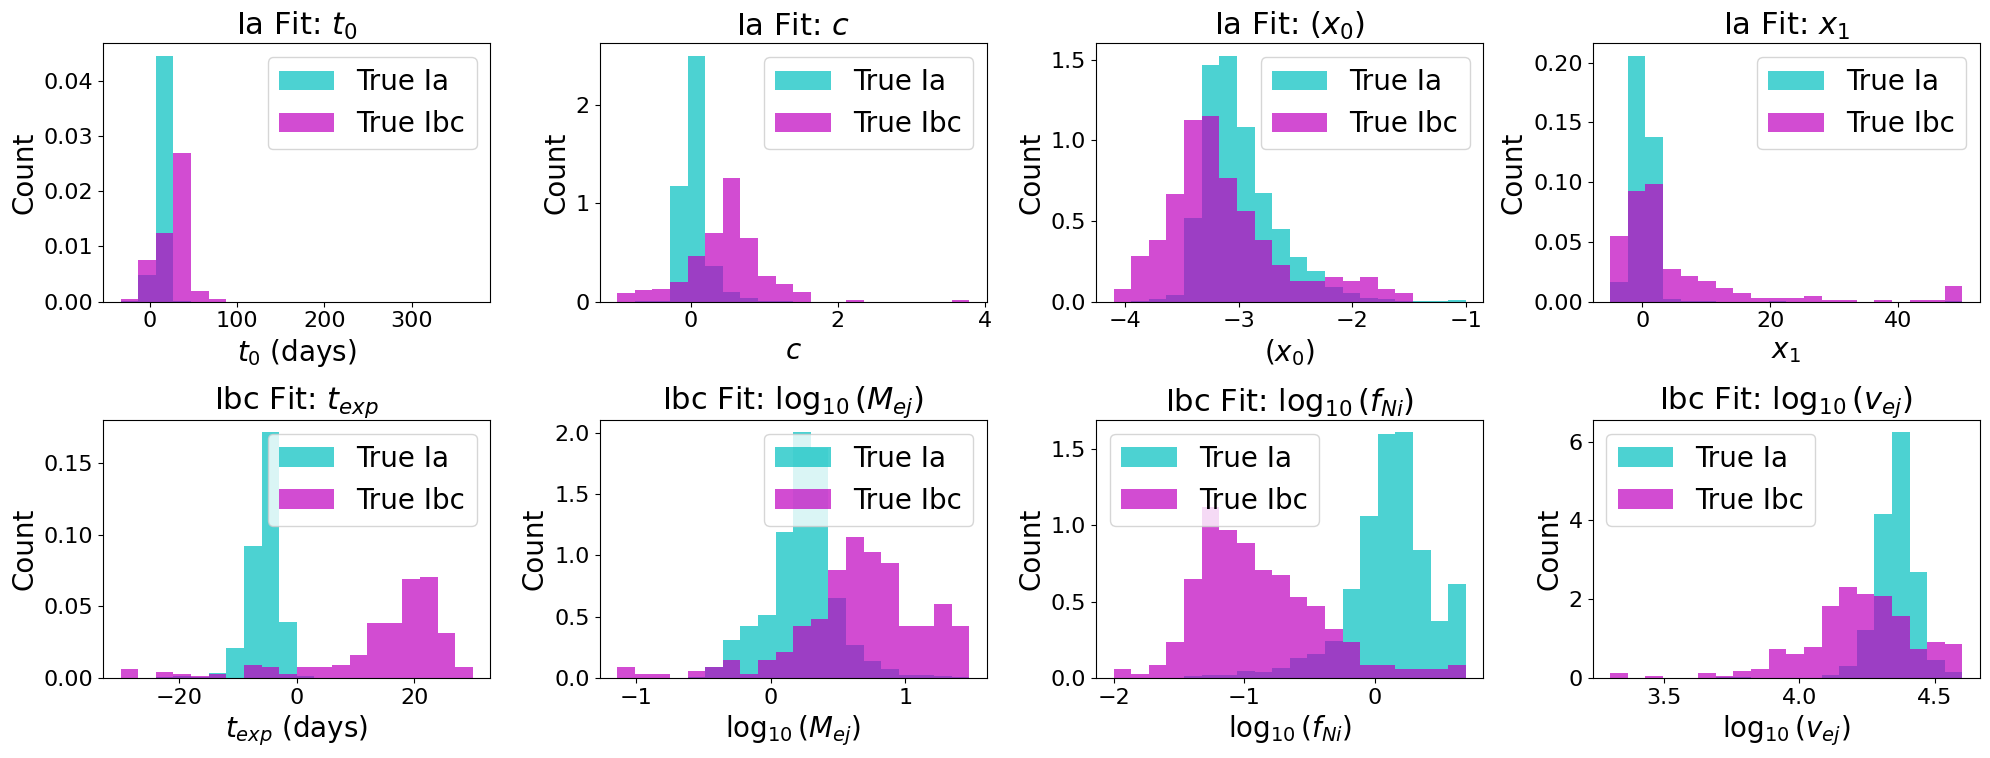

In [293]:
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',

    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',

    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$(x_0)$',
}

param_labels_no_units = {
    't0': r'$t_0$',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$',
    'mej': r'$M_{ej}$',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$(x_0)$',
}


labelfontsize = 20
titlefontsize = 22
tickfontsize = 16

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
# fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names[:4]):
for i, param in enumerate(['t0', 'c', 'x0', 'x1']):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=True)
    axes[0, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=True)
    axes[0, i].set_title(f"Ia Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[0, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[0, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[0, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[0, i].legend(fontsize=labelfontsize)

# Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
for i, param in enumerate(['texp', 'log_mej',  'log_fni', 'log_vej']):

    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=True)
    axes[1, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=True)
    axes[1, i].set_title(f"Ibc Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[1, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[1, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[1, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[1, i].legend(fontsize=labelfontsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [294]:
# fig.savefig("figures/fitted_params_histogram.pdf", bbox_inches='tight')

Here we have 8 parameters that we can use to constrain the mixing fraction

In [295]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [296]:
def get_param_samples(param_name, sn_sample = all_sne):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in sn_sample])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in sn_sample])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([2.632e+03, 2.700e+01, 8.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([7.88257576e-05, 1.00709432e-02, 2.00630606e-02, 3.00551780e-02,
        4.00472955e-02, 5.00394129e-02, 6.00315303e-02, 7.00236477e-02,
        8.00157652e-02, 9.00078826e-02, 1.00000000e-01]),
 <BarContainer object of 10 artists>)

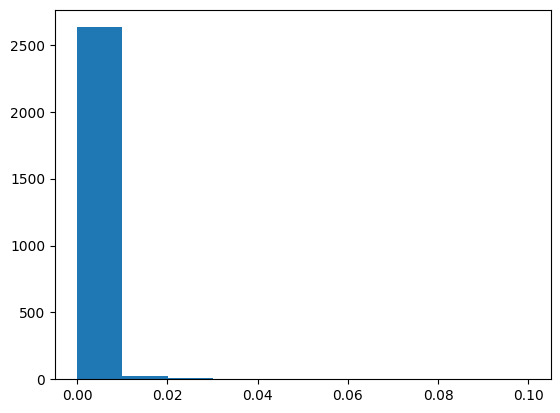

In [297]:
plt.hist(get_param_samples('x0'))

In [298]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(2674, 1)

In [299]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'log_x1', 'log_x0', 'log_fni', 'log_vej', 'x1', 'x0', 'fni']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    # samples = get_param_samples(param_name).reshape(-1, 1)
    # gm = GaussianMixture(n_components=2).fit(samples)
    # mus_a[param_name] = gm.means_[0][0]
    # mus_b[param_name] = gm.means_[1][0]
    # sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    # sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    # print(param_name, gm.weights_, sigmas_a[param_name], sigmas_b[param_name])
    mus_a[param_name] = np.median(get_param_samples(param_name)) - np.std(get_param_samples(param_name))
    mus_b[param_name] = np.median(get_param_samples(param_name)) + np.std(get_param_samples(param_name))
    sigmas_a[param_name] = np.std(get_param_samples(param_name))
    sigmas_b[param_name] = np.std(get_param_samples(param_name))

In [300]:
num_epochs = 200
lls = np.zeros(num_epochs)

alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': []}

# params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
# params_to_use = ['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']
params_to_use = ['c', 'mej', 'log_x0']

# params_to_use = list(mus_a.keys())  # Use all parameters for fitting

sigma_clip_masks = {}
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    clipped = sigma_clip(param_samples, sigma=10, maxiters=3)
    sigma_clip_masks[param_name] = ~clipped.mask
    sigma_clip_masks[param_name] = np.ones_like(sigma_clip_masks[param_name])
    print(f"{param_name}: {sum(clipped.mask)} samples clipped")


len(all_sne), len(true_ia_sne)/len(all_sne)

weights = np.ones(len(all_sne))
for i, sn in enumerate(true_ia_sne):
    weights[i] = len(true_ia_sne) / (len(all_sne) - len(true_ia_sne))
    weights[i] = 1.0

# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)
        mask = sigma_clip_masks[param_name]
        param_samples = param_samples[mask]
        these_weights = weights[mask]

        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        # mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        # mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        # sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        # sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))


        mus_a[param_name] = np.sum(these_weights * gammas_a[param_name] * param_samples) / np.sum(these_weights * gammas_a[param_name])
        mus_b[param_name] = np.sum(these_weights * gammas_b[param_name] * param_samples) / np.sum(these_weights * gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(these_weights * gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(these_weights * gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(these_weights * gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(these_weights * gammas_b[param_name]))

        if sigmas_a[param_name] < 0.001:
            sigmas_a[param_name] = 0.001
        if sigmas_b[param_name] < 0.001:
            sigmas_b[param_name] = 0.001
    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], 
                                     get_param_samples(param_name)[sigma_clip_masks[param_name]], alpha)

print(lls[-1])
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
    gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    gamma_total = (gammas_a[param_name] + gammas_b[param_name])
    gammas_a[param_name] /= gamma_total
    gammas_b[param_name] /= gamma_total
    

c: 1 samples clipped
mej: 0 samples clipped
log_x0: 0 samples clipped
Alpha 0.12129403506251878
Alpha 0.17666238848976668
Alpha 0.27950541993485833
Alpha 0.39804603634076624
Alpha 0.49779416977580093
Alpha 0.5713903891641802
Alpha 0.625250995443274
Alpha 0.6656304151344012
Alpha 0.6965982102205562
Alpha 0.7206976133511791
Alpha 0.7396091798778801
Alpha 0.7545265068596817
Alpha 0.7663355363464937
Alpha 0.7757084421327117
Alpha 0.7831621251903528
Alpha 0.7890981110311244
Alpha 0.7938306938472415
Alpha 0.7976072510589666
Alpha 0.8006232438128174
Alpha 0.8030335233245922
Alpha 0.8049609937252302
Alpha 0.8065033303090876
Alpha 0.8077382341900481
Alpha 0.8087275658999373
Alpha 0.809520609287118
Alpha 0.8101566547436047
Alpha 0.8106670466217127
Alpha 0.8110768073776446
Alpha 0.8114059266750846
Alpha 0.8116703850209549
Alpha 0.8118829669636957
Alpha 0.812053907444391
Alpha 0.8121914058428453
Alpha 0.8123020350868557
Alpha 0.8123910675019766
Alpha 0.8124627345667355
Alpha 0.812520434163854
Alph

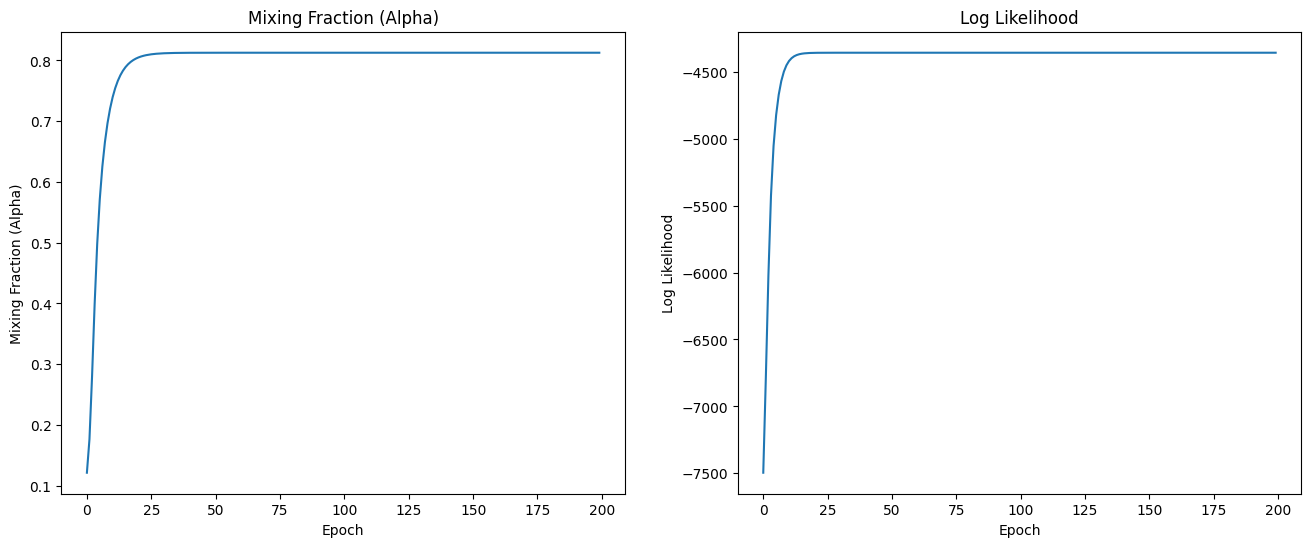

In [301]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [302]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  19.,    8.,   36.,  194.,   36.,   47.,  271.,  172.,  205.,
        1686.]),
 array([2.44196795e-05, 9.66311572e-02, 1.93237895e-01, 2.89844632e-01,
        3.86451370e-01, 4.83058107e-01, 5.79664845e-01, 6.76271582e-01,
        7.72878320e-01, 8.69485057e-01, 9.66091795e-01]),
 <BarContainer object of 10 artists>)

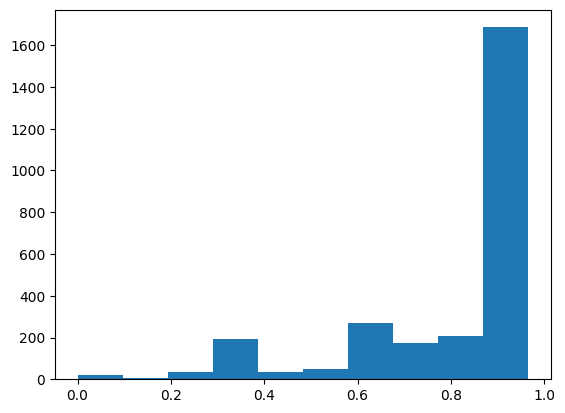

In [303]:
plt.hist(prob_a)

In [304]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in all_sne]

# true_classes

2289 168 133 84
0.918848167539267


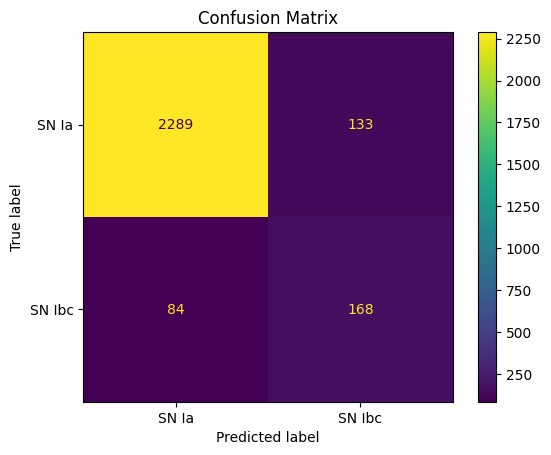

Ia accuracy: 0.9450867052023122
Ibc accuracy: 0.6666666666666666


In [305]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("Ia accuracy:", (num_correct_ia) / (num_correct_ia + num_wrong_true_ia))
print("Ibc accuracy:", (num_correct_ibc) / (num_correct_ibc + num_wrong_true_ibc))

In [306]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a >=4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


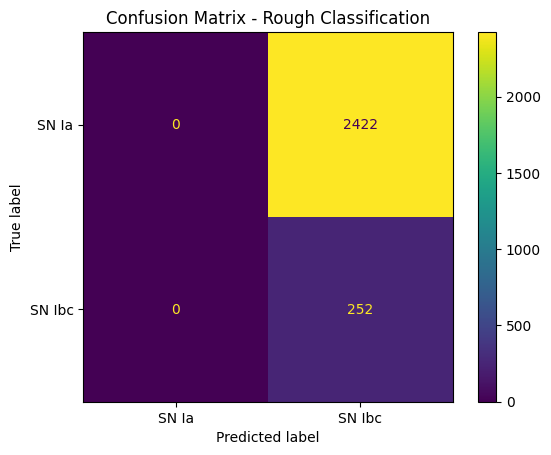

0 252 2422 0
0.09424083769633508


In [307]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

cm = confusion_matrix(true_classes, classifications_rough, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix - Rough Classification")
plt.show()

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

In [308]:
params_to_use

['c', 'mej', 'log_x0']

{'c': 0.6072646276424719, 'mej': 0.5772805065524486, 'log_x0': 1.0072934441022672}
2289 158 133 94
0.9151084517576664


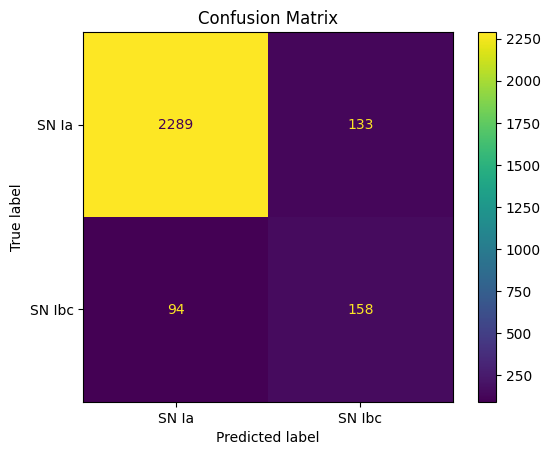

Ia accuracy: 0.9450867052023122
Ibc accuracy: 0.626984126984127


In [309]:
from scipy.stats import entropy
from scipy.special import kl_div

param_weights = {}
for param in params_to_use:
    # ia_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
    #            for sn in true_ia_sne]
    # ibc_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
    #             for sn in true_ibc_sne]
    
    # # Use histogram-based KL divergence as weight
    # bins = np.histogram_bin_edges(ia_vals + ibc_vals, bins=30)
    # p_ia, _ = np.histogram(ia_vals, bins=bins, density=True)
    # p_ibc, _ = np.histogram(ibc_vals, bins=bins, density=True)
    # p_ia = p_ia + 1e-100  # avoid zeros
    # p_ibc = p_ibc + 1e-100
    # param_weights[param] = entropy(p_ia, p_ibc)
    param_weights[param] = 1 / entropy(gammas_a[param], gammas_b[param])
    # param_weights[param] = 1 / kl_div(gammas_a[param], gammas_b[param]).sum()
    # print(param_weights[param], param_weights[param].sum())


# Then in classification:
weighted_probs = np.zeros(len(all_sne))
for i in range(len(all_sne)):
    weighted_probs[i] = sum(param_weights[p] * gammas_a[p][i] for p in params_to_use) / \
                sum(param_weights[p] * (gammas_a[p][i] + gammas_b[p][i]) for p in params_to_use)

print(param_weights)

# Classify SNe based on weighted probabilities
weighted_classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in weighted_probs]
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, weighted_classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, weighted_classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("Ia accuracy:", (num_correct_ia) / (num_correct_ia + num_wrong_true_ia))
print("Ibc accuracy:", (num_correct_ibc) / (num_correct_ibc + num_wrong_true_ibc))

In [310]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [311]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

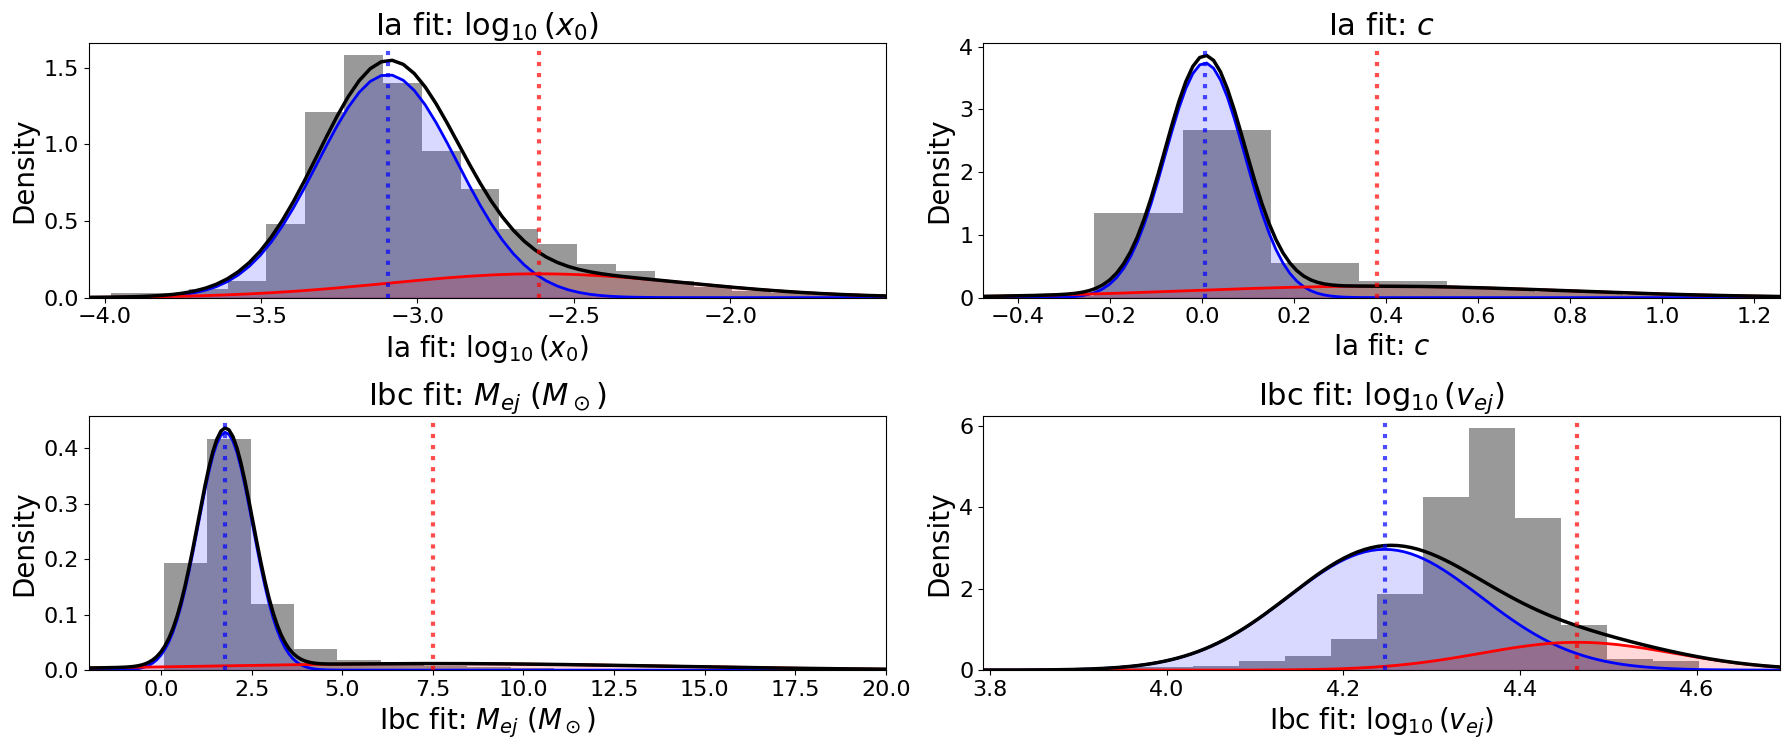


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
log_x0          -3.0954     0.2231    -2.6120     0.4810
c                0.0065     0.0866     0.3800     0.4081
mej              1.7710     0.7568     7.5000     6.3153
log_vej          4.2466     0.1091     4.4649     0.1091


In [312]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-50, 100, 200),
    'log_x0': np.linspace(-6, 1, 200),
    'x1': np.linspace(-5, 50, 200),
    'c': np.linspace(-1, 2, 200),
    'texp': np.linspace(-20, 50, 200),
    'mej': np.linspace(-2, 20, 200),
    'log_fni': np.linspace(-3, 2, 200),
    'fni': np.linspace(0, 3, 200),
    'log_vej': np.linspace(3.5, 5, 200),
    'log_x1': np.linspace(-2, 2, 200),
    'log_mej': np.linspace(-1, 2, 200)
}

# Parameter display names
param_labels = {
    't0': r'Ia fit: $t_0$ (days)',
    'log_x0': r'Ia fit: $\log_{10}(x_0)$',
    'log_x1': r'Ia fit: $\log_{10}(x_1 + 5)$',
    'x1': r'Ia fit: $x_1$',
    'c': r'Ia fit: $c$',
    'texp': r'Ibc fit: $t_{exp}$ (days)',
    'mej': r'Ibc fit: $M_{ej}$ ($M_\odot$)',
    'log_fni': r'Ibc fit: $\log_{10}(f_{Ni})$',
    'fni': r'Ibc fit: $f_{Ni}$',
    'log_vej': r'Ibc fit: $\log_{10}(v_{ej})$',
    'log_mej': r'Ibc fit: $\log_{10}(M_{ej})$'   
}

# Create figure with better styling
# fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

# params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']
# params_plot = ['log_x0', 'x1', 'c', 'mej', 'log_fni', 'log_vej']
params_plot = ['log_x0','c', 'mej', 'log_vej']

fig, axes = plt.subplots(2, len(params_plot) // 2, figsize=(18, 8))


for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True,  alpha=0.4,
                                color='black', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=labelfontsize)
    ax.set_ylabel('Density', fontsize=labelfontsize)
    ax.set_title(param_labels[param], fontsize=titlefontsize)
    # ax.legend(fontsize=labelfontsize, loc='upper right')
    ax.tick_params(axis='both', labelsize=tickfontsize)

    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=3)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("figures/gmm_results.pdf", bbox_inches='tight')

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")

In [313]:
def fit_gmm(sn_sample = all_sne, initial_alpha = 0.1, verbose = False):

    # Fit initial guesses
    # params_to_use = ['t0', 'c', 'log_mej', 'mej', 'texp', 'log_x1', 'log_x0', 'log_fni', 'log_vej']

    mus_a = {}
    mus_b = {}
    sigmas_a = {}
    sigmas_b = {}

    # params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
    params_to_use = ['c', 'mej', 'log_x0']

    print(len(sn_sample))
    
    # Initialize parameters
    for param_name in params_to_use:
        mus_a[param_name] = np.median(get_param_samples(param_name, sn_sample)) - np.std(get_param_samples(param_name, sn_sample))
        mus_b[param_name] = np.median(get_param_samples(param_name, sn_sample)) + np.std(get_param_samples(param_name, sn_sample))
        sigmas_a[param_name] = np.std(get_param_samples(param_name, sn_sample))
        sigmas_b[param_name] = np.std(get_param_samples(param_name, sn_sample))

    num_epochs = 200
    lls = np.zeros(num_epochs)

    alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
    alpha = initial_alpha  # Mixing fraction initilization
    gammas_a = {'texp': [], 'mej': [], 'log_mej':[], 'log_fni': [], 'fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'log_x1': [], 'c': []}
    gammas_b = {'texp': [], 'mej': [], 'log_mej':[], 'log_fni': [], 'fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'log_x1': [], 'c': []}



    # there are two populations, a and b
    for epoch in range(num_epochs):
        # for param_name in list(mus_a.keys())[:3]:
        for param_name in params_to_use:
            param_samples = get_param_samples(param_name, sn_sample)

            # the gammas are weights for every sample
            gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
            gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    
            # Normalize over parameter
            gamma_total = (gammas_a[param_name] + gammas_b[param_name])
            gammas_a[param_name] /= gamma_total
            gammas_b[param_name] /= gamma_total
            

            mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
            mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
            sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
            sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

            if sigmas_a[param_name] < 0.001:
                sigmas_a[param_name] = 0.001
            if sigmas_b[param_name] < 0.001:
                sigmas_b[param_name] = 0.001

        
        # Here we can use information from all parameters to constrain the mixing fraction
        # alpha is the fraction of parameter a, parameter b has 1 - alpha
        alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
        alphas[epoch] = alpha
        if verbose:
            print("Alpha", alpha)

        # Calculate log likelihood for the current epoch
        for param_name in params_to_use:
            lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]],
                                         get_param_samples(param_name, sn_sample), alpha)
    return alpha, lls[-1], gammas_a, gammas_b
        

In [314]:
def classify_sample(sn_sample, gammas_a, gammas_b):

    prob_a = np.ones(len(sn_sample))

    print(params_to_use)
    for i in range(len(sn_sample)):
        s = 0
        b = 0
        for param in params_to_use:
            s += gammas_a[param][i]
            b += gammas_b[param][i]
        prob_a[i] = s / (s + b)

    classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    # Calculate accuracy
    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0

    for a,b in zip(true_classes, classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    ia_accuracy = num_correct_ia / (num_correct_ia + num_wrong_true_ia)
    ibc_accuracy = num_correct_ibc / (num_correct_ibc + num_wrong_true_ibc)
    return accuracy, ia_accuracy, ibc_accuracy

In [315]:
def classify_sample_entropy(sn_sample, gammas_a, gammas_b):
    param_weights = {}
    for param in params_to_use:
        param_weights[param] = 1 / entropy(gammas_a[param], gammas_b[param])

    # Then in classification:
    weighted_probs = np.zeros(len(sn_sample))
    for i in range(len(sn_sample)):
        weighted_probs[i] = sum(param_weights[p] * gammas_a[p][i] for p in params_to_use) / \
                    sum(param_weights[p] * (gammas_a[p][i] + gammas_b[p][i]) for p in params_to_use)

    print(param_weights)

    # Classify SNe based on weighted probabilities
    weighted_classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in weighted_probs]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0


    for a,b in zip(true_classes, weighted_classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    ia_accuracy = num_correct_ia / (num_correct_ia + num_wrong_true_ia)
    ibc_accuracy = num_correct_ibc / (num_correct_ibc + num_wrong_true_ibc)
    return accuracy, ia_accuracy, ibc_accuracy

In [316]:
fit_gmm(sn_sample = all_sne, initial_alpha = 0.6)
for i in range(1,10):
    print(f"Initial alpha: {i/10}")
    final_alpha, final_ll, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = all_sne, initial_alpha = i/10)
    print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
    print("Classification accuracy:", classify_sample(all_sne, final_gammas_a, final_gammas_b)[0])


2674
Initial alpha: 0.1
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.2
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.3
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.4
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.5
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.6
2674
Final alpha: 0.8127594532340645 Final log likelihood: -4357.733627088418
['c', 'mej', 'log_x0']
Classification accuracy: 0.918848167539267
Initial alpha: 0.

In [317]:
len(true_ia_sne), len(true_ibc_sne)

(2422, 252)

2673
['c', 'mej', 'log_x0']
2423
['c', 'mej', 'log_x0']
2173
['c', 'mej', 'log_x0']
1923
['c', 'mej', 'log_x0']
1673
['c', 'mej', 'log_x0']
1423
['c', 'mej', 'log_x0']
1173
['c', 'mej', 'log_x0']
923
['c', 'mej', 'log_x0']
673
['c', 'mej', 'log_x0']
423
['c', 'mej', 'log_x0']


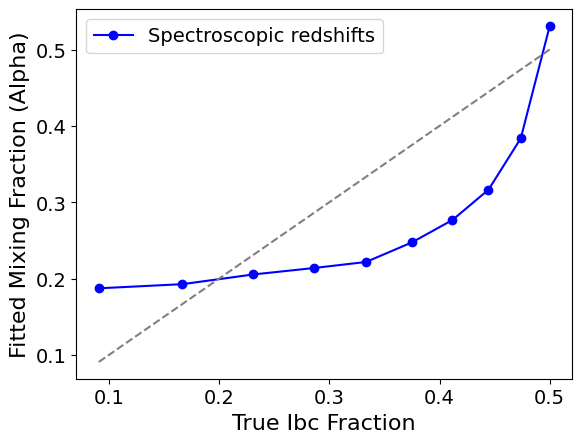

In [320]:
ratios = [(25 * (i + 1))/ (25 * (i + 1) + 250) for i in range(10)]

def mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios):
    final_alphas = []
    accuracies = np.zeros((3, len(ratios)))
    for i in range(10):
        # print(25*(i + 1))
        # split_population = np.concatenate((true_ia_sne, true_ibc_sne[1:25*(i + 1)]))
        split_population = np.concatenate((true_ia_sne[1:len(true_ia_sne)-250*i], true_ibc_sne))

        # print(f"Population split: {(25 * (i + 1))/ (25 * (i + 1) + 250)}")
        # final_alpha, final_ll = fit_gmm(sn_sample = split_population, initial_alpha = (25 * (i + 1))/ (25 * (i + 1) + 250))
        final_alpha, final_ll, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = split_population, initial_alpha = 0.1)
        # print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
        final_alphas.append(final_alpha)
        accuracies[:, i] = classify_sample(split_population, final_gammas_a, final_gammas_b)
    return final_alphas, accuracies

final_alphas_spec, accuracies_spec = mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios)
# final_alphas_phot, accuracies_phot = mixing_fraction_analysis(true_ia_phot_sne, true_ibc_phot_sne, ratios)

plt.plot(ratios, 1 - np.array(final_alphas_spec), marker='o', color='blue', label='Spectroscopic redshifts')
# plt.plot(ratios, 1 - np.array(final_alphas_phot), marker='o', color='red', label='Photometric redshifts')
plt.plot(ratios, ratios, linestyle='--', color='gray')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Fitted Mixing Fraction (Alpha)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

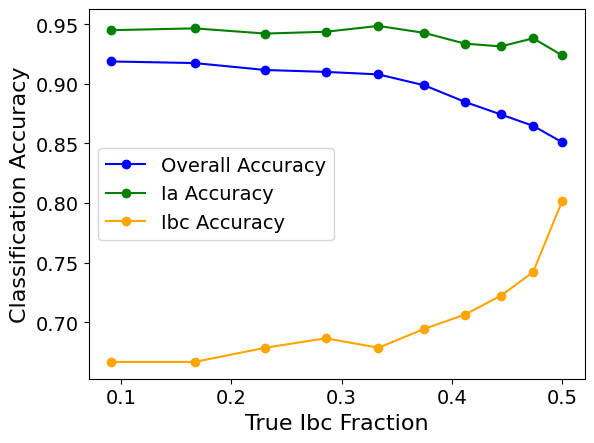

In [321]:
plt.plot(ratios, accuracies_spec[0,:], marker='o', color='blue', label='Overall Accuracy')
plt.plot(ratios, accuracies_spec[1,:], marker='o', color='green', label='Ia Accuracy')
plt.plot(ratios, accuracies_spec[2,:], marker='o', color='orange', label='Ibc Accuracy')

# plt.plot(ratios, accuracies_phot[0,:], marker='o', color='red', label='Photometric redshifts')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()